In [47]:
import pandas as pd
import numpy as np

In [48]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

In [49]:
feature = pd.read_csv("training_set_features.csv")

In [50]:
label = pd.read_csv("training_set_labels.csv")

In [51]:
pd.set_option('display.max_rows', 50)

In [52]:
df = pd.merge(left=feature, right=label, left_on="respondent_id", right_on="respondent_id")

In [53]:
df.shape

(26707, 38)

In [54]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [55]:
#df.info();

In [56]:
df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [57]:
#columns "health_insurance", "employment_industry", "employment_occupation" contain too many null values hence droping it
df = df.drop(["health_insurance", "employment_industry", "employment_occupation"], axis=1)

In [58]:
df.shape

(26707, 35)

In [59]:
pd.unique(df.h1n1_concern)

array([ 1.,  3.,  2.,  0., nan])

In [60]:
df.loc[0]

respondent_id                                   0
h1n1_concern                                    1
h1n1_knowledge                                  0
behavioral_antiviral_meds                       0
behavioral_avoidance                            0
behavioral_face_mask                            0
behavioral_wash_hands                           0
behavioral_large_gatherings                     0
behavioral_outside_home                         1
behavioral_touch_face                           1
doctor_recc_h1n1                                0
doctor_recc_seasonal                            0
chronic_med_condition                           0
child_under_6_months                            0
health_worker                                   0
opinion_h1n1_vacc_effective                     3
opinion_h1n1_risk                               1
opinion_h1n1_sick_from_vacc                     2
opinion_seas_vacc_effective                     2
opinion_seas_risk                               1


In [61]:
# remove duplicate rows 

df = df.drop_duplicates()

In [62]:
df.shape

(26707, 35)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [64]:
#Treating Missing Values
#Numerical columns with Median
for col in df.columns: 
    if df[col].isnull().sum() >=1 and df[col].dtypes != "object":
        df[col].loc[(df[col].isnull())] = df[col].median()
#Categorical columns with Mode
for col in df.columns:
    if df[col].isnull().sum() >=1 and df[col].dtypes == "object":
        df[col].loc[(df[col].isnull())] = df[col].mode().max() 


C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
df.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

In [66]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


In [67]:
#how many unique values does each variable have
var_uniq_count = []
colnames = df.columns
counter = 1
for col in colnames:
    x = len(df[col].unique()) # how many unique values does this variable take in the data
    var_uniq_count = np.append(var_uniq_count, x) # # fill this value into the array
    counter=counter+1
    

df_unique_values = pd.DataFrame({"variable" : colnames, "u_values": var_uniq_count})
df_unique_values
    
    

,variable,u_values
0,respondent_id,26707.0
1,h1n1_concern,4.0
2,h1n1_knowledge,3.0
3,behavioral_antiviral_meds,2.0
4,behavioral_avoidance,2.0
5,behavioral_face_mask,2.0
6,behavioral_wash_hands,2.0
7,behavioral_large_gatherings,2.0
8,behavioral_outside_home,2.0
9,behavioral_touch_face,2.0


In [68]:
# Define a function to calculate frequency tables 
def frequency_table(x, df):
    freq = df[x].value_counts()
    return(freq)

In [69]:
(2899/26707)*100

10.85483206649942

In [70]:
# Study the frequency table for each column (except the first two, as those are identifiers)

for col in colnames[1:]:
    print("\n\n--------------------Next Features--------")
    print(col)
    print(frequency_table(col,df))




--------------------Next Features--------
h1n1_concern
2.0    10667
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64


--------------------Next Features--------
h1n1_knowledge
1.0    14714
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64


--------------------Next Features--------
behavioral_antiviral_meds
0.0    25406
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64


--------------------Next Features--------
behavioral_avoidance
1.0    19436
0.0     7271
Name: behavioral_avoidance, dtype: int64


--------------------Next Features--------
behavioral_face_mask
0.0    24866
1.0     1841
Name: behavioral_face_mask, dtype: int64


--------------------Next Features--------
behavioral_wash_hands
1.0    22057
0.0     4650
Name: behavioral_wash_hands, dtype: int64


--------------------Next Features--------
behavioral_large_gatherings
0.0    17160
1.0     9547
Name: behavioral_large_gatherings, dtype: int64


--------------------Next Features----

In [71]:
# drop  "behavioral_antiviral_meds", "behavioral_face_mask", "child_under_6_months", "health_worker" as it is a redundant data
df = df.drop(["behavioral_antiviral_meds", "behavioral_face_mask", "child_under_6_months", "health_worker"], axis=1)

In [72]:
df.shape

(26707, 31)

In [73]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_avoidance', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [74]:
column = ['h1n1_concern', 'h1n1_knowledge',
       'behavioral_avoidance', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children']

In [75]:
import scipy.stats as stats

In [76]:
# CHiSQ test

for col in column:
    crosstab = pd.crosstab(df["h1n1_vaccine"], df[col])
    result = stats.chi2_contingency(crosstab) 
    print("\n\n--------------------Next Features--------")
    print("CHIsq Test")
    print(col)
    print(result)
    



--------------------Next Features--------
CHIsq Test
h1n1_concern
(400.4620379252815, 1.7582253892199257e-86, 3, array([[2595.752724  , 6420.86527877, 8400.75676789, 3615.62522934],
       [ 700.247276  , 1732.13472123, 2266.24323211,  975.37477066]]))


--------------------Next Features--------
CHIsq Test
h1n1_knowledge
(396.7931990299987, 6.877832615401085e-87, 2, array([[ 1973.59111843, 11587.95679035,  7471.45209121],
       [  532.40888157,  3126.04320965,  2015.54790879]]))


--------------------Next Features--------
CHIsq Test
behavioral_avoidance
(58.330240730060524, 2.2161129058289884e-14, 1, array([[ 5726.24941027, 15306.75058973],
       [ 1544.75058973,  4129.24941027]]))


--------------------Next Features--------
CHIsq Test
behavioral_wash_hands
(148.02701040329165, 4.679794352605926e-34, 1, array([[ 3662.09046317, 17370.90953683],
       [  987.90953683,  4686.09046317]]))


--------------------Next Features--------
CHIsq Test
behavioral_large_gatherings
(8.64663809200

In [77]:
# As CHIsq Test P-values is more than 0.05 we can drop cloumns "census_msa", "household_children"
df = df.drop(["census_msa", "household_children"], axis=1)

In [78]:
df.shape

(26707, 29)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26707 non-null  float64
 2   h1n1_knowledge               26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_wash_hands        26707 non-null  float64
 5   behavioral_large_gatherings  26707 non-null  float64
 6   behavioral_outside_home      26707 non-null  float64
 7   behavioral_touch_face        26707 non-null  float64
 8   doctor_recc_h1n1             26707 non-null  float64
 9   doctor_recc_seasonal         26707 non-null  float64
 10  chronic_med_condition        26707 non-null  float64
 11  opinion_h1n1_vacc_effective  26707 non-null  float64
 12  opinion_h1n1_risk            26707 non-null  float64
 13  opinion_h1n1_sic

In [80]:
df_vif = df._get_numeric_data()
df_vif = df_vif.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis =1)
df_vif

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0
1,3.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,0.0
4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,2.0,2.0,0.0
26703,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,1.0,1.0,1.0
26704,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,4.0,2.0,0.0
26705,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,1.0


## VIF TEST

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [82]:
X = add_constant(df_vif)

In [83]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                          29.590252
h1n1_concern                    1.435709
h1n1_knowledge                  1.053161
behavioral_avoidance            1.237079
behavioral_wash_hands           1.287366
behavioral_large_gatherings     1.578766
behavioral_outside_home         1.580210
behavioral_touch_face           1.288442
doctor_recc_h1n1                1.656996
doctor_recc_seasonal            1.667197
chronic_med_condition           1.075593
opinion_h1n1_vacc_effective     1.361670
opinion_h1n1_risk               1.675286
opinion_h1n1_sick_from_vacc     1.513514
opinion_seas_vacc_effective     1.418496
opinion_seas_risk               1.671386
opinion_seas_sick_from_vacc     1.351494
household_adults                1.011310
dtype: float64

In [84]:
str_cols = df.select_dtypes(include = 'object').columns
df[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun


In [85]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

LE = LabelEncoder()
for col in str_cols:
    df[col] = LE.fit_transform(df[col]) # Converts to int64


In [86]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,household_adults,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3,0,2,1,0,1,8,0.0,0,0
1,1,3.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3,1,2,1,1,0,1,0.0,0,1
2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,1,0,1,0,0,9,2.0,0,0
3,3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,3,0,2,1,1,1,5,0.0,0,1
4,4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,3,0,0,0,0,0,9,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,0,1,9,0.0,0,0
26703,26703,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,3,1,0,1,1,0,6,1.0,0,0
26704,26704,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,3,0,0,1,0,0,6,0.0,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,5,1.0,0,0


In [87]:
df = df.drop(['respondent_id'], axis=1)

In [88]:
Lable = df[['h1n1_vaccine', 'seasonal_vaccine']]
Lable.head()

,h1n1_vaccine,seasonal_vaccine
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [89]:
feature = df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis = 1)


In [90]:
feature.head()

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,...,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,household_adults
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3,1,3,0,2,1,0,1,8,0.0
1,3.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1,0,3,1,2,1,1,0,1,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,2,3,1,0,1,0,0,9,2.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,4,0,3,0,2,1,1,1,5,0.0
4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2,3,3,0,0,0,0,0,9,1.0


###  Splitting Data

In [175]:
# Creating/Spliting Test &  Train Dataset
x_train, x_test, y_train, y_test = train_test_split(feature, Lable, test_size = 0.25, random_state = 143)

In [176]:
print((x_train.shape, x_test.shape, y_train.shape, y_test.shape))

((20030, 26), (6677, 26), (20030, 2), (6677, 2))


In [101]:
y_train.head(), y_test.head()

(       h1n1_vaccine  seasonal_vaccine
 14081             0                 1
 5186              0                 0
 3317              1                 1
 6778              0                 0
 17624             1                 1,
        h1n1_vaccine  seasonal_vaccine
 24778             1                 1
 2183              0                 0
 16188             0                 1
 17334             1                 1
 3044              0                 1)

In [165]:
y_train = y_train.iloc[:,0]  #First assigning to check for H1_N1_VACCINE the target labels
y_test = y_test.iloc[:,0]    # Below after H1_N1 is completed we have to reinitialise splitting 
#the data to run for Seasonal Flu vaccine target lables***** Imp

# MODEL performance evaluation 

In [139]:
# Defining function that computes model performance 
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [134]:
def model_performance(model):
    RF_training_labels = model.predict(x_train)
    RF_test_labels = model.predict(x_test)
    Training_accuracy = model.score(x_train, y_train, sample_weight=None)
    Test_accuracy = model.score(x_test, y_test, sample_weight=None)
    F1_score_train = f1_score(y_train, RF_training_labels, average = 'weighted')
    F1_score_test = f1_score(y_test, RF_test_labels, average = 'weighted')
    Recall_train = recall_score(y_train, RF_training_labels, average = 'weighted') 
    Recall_test  = recall_score(y_test, RF_test_labels, average = 'weighted') 
    Precision_train = precision_score(y_train, RF_training_labels, average = 'weighted')
    Precision_test = precision_score(y_test, RF_test_labels, average = 'weighted')
    rf_cm_tr = confusion_matrix(y_train, RF_training_labels)
    rf_cm_te = confusion_matrix(y_test, RF_test_labels)
    print("Training_accuracy - ", Training_accuracy)
    print("Test_accuracy - ", Test_accuracy)
    print("F1_score_train - ", F1_score_train)
    print("F1_score_test - ", F1_score_test)
    print("Recall_train - ", Recall_train)
    print("Recall_test - ", Recall_test)
    print("Precision_train - ", Precision_train)
    print("Precision_test - ", Precision_test)
    print("Training_Confusion_Matrix - ", rf_cm_tr)
    #print("Test Confusion Matrix - ", rf_cm_te)
    
    #Confusion Matrix
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(rf_cm_te), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Test Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    
    
    return RF_training_labels, RF_test_labels 

# h1n1_vaccine

### Log Reg

Text(0.5, 257.44, 'Predicted label')

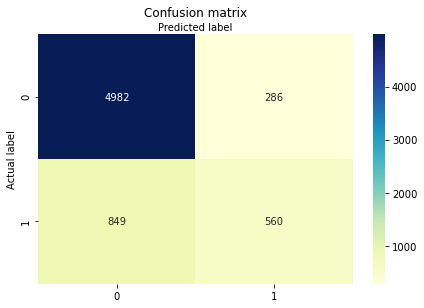

In [143]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
log_reg = logreg.fit(x_train, y_train)

# fit the model with data
#logreg.fit(train_x,train_y2)

#
y_pred=log_reg.predict(x_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


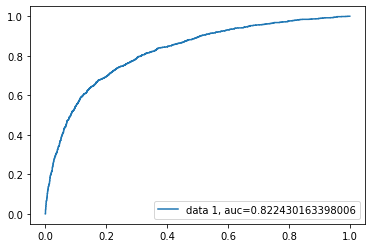

In [144]:
#AuRoc Curve
y_pred_proba = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### XGBoost Classifier

In [166]:
import xgboost
from xgboost import XGBClassifier
model =XGBClassifier(gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=11, seed=0, silent=True, subsample=1).fit(x_train,y_train)

[18:27:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Training_accuracy -  0.6010983524712931
Test_accuracy -  0.5837951175677699
F1_score_train -  0.6325261692891824
F1_score_test -  0.6170281173990593
Recall_train -  0.6010983524712931
Recall_test -  0.5837951175677699
Precision_train -  0.8324341713465766
Precision_test -  0.816238753941102
Training_Confusion_Matrix -  [[8063 7702]
 [ 288 3977]]


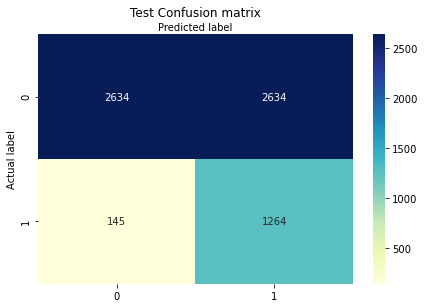

In [167]:
XG_training_labels, XG_test_labels = model_performance(model)

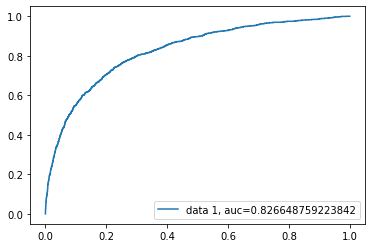

In [168]:
#AuRoc Curve
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random Forest Classifier

In [169]:
# ----------------- MODEL TRAINING USING RANDOM FOREST -------------------
RF_model = RandomForestClassifier(max_depth=6, random_state=0).fit(x_train,y_train)

Training_accuracy -  0.8339990014977534
Test_accuracy -  0.8295641755279317
F1_score_train -  0.8093334459661916
F1_score_test -  0.8032274645386064
Recall_train -  0.8339990014977534
Recall_test -  0.8295641755279317
Precision_train -  0.8217044248110638
Precision_test -  0.8146292578118376
Training_Confusion_Matrix -  [[15242   523]
 [ 2802  1463]]


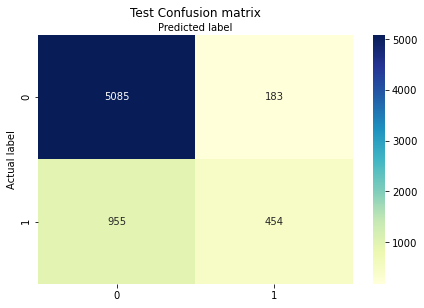

In [152]:
# -------------------- RANDOM FOREST RESULTS ------------------- 
RF_training_labels, RF_test_labels = model_performance(RF_model)

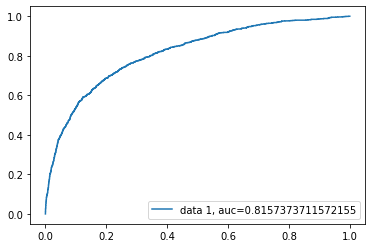

In [170]:
#AuRoc Curve
y_pred_proba = RF_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Light GBM

In [171]:
# ------------------- MODEL TRAINING USING LightGBM ---------------------
LGBMClassifier = lgb.LGBMClassifier().fit(x_train,y_train)

Training_accuracy -  0.8641038442336495
Test_accuracy -  0.8351055863411712
F1_score_train -  0.8540623047545071
F1_score_test -  0.8227120975458725
Recall_train -  0.8641038442336495
Recall_test -  0.8351055863411712
Precision_train -  0.8562714666302846
Precision_test -  0.8213265219703845
Training_Confusion_Matrix -  [[15082   683]
 [ 2039  2226]]


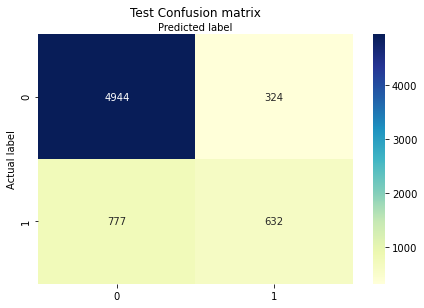

In [155]:
# -------------------- LIGHT GBM RESULTS ------------------- 
LGBM_training_labels, LGBM_test_labels = model_performance(LGBMClassifier)

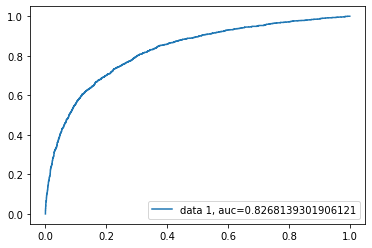

In [172]:
#AuRoc Curve
y_pred_proba = LGBMClassifier.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Seasonal FLU vaccine

In [177]:
y_train.shape

(20030, 2)

In [178]:
y_train = y_train.iloc[:,1]
y_test = y_test.iloc[:,1]

Training_accuracy -  0.7697453819271093
Test_accuracy -  0.7687584244421147
F1_score_train -  0.7690816275585891
F1_score_test -  0.768180953694829
Recall_train -  0.7697453819271093
Recall_test -  0.7687584244421147
Precision_train -  0.7697301962629062
Precision_test -  0.7686808183600944
Training_Confusion_Matrix -  [[8693 2015]
 [2597 6725]]


(array([0, 0, 1, ..., 0, 0, 1], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 1], dtype=int64))

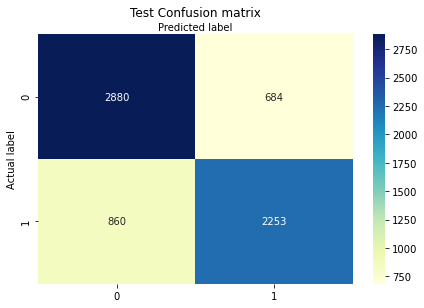

In [182]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg2 = LogisticRegression()

# fit the model with data
logreg2.fit(x_train,y_train)

#
y_pred=logreg2.predict(x_test)

model_performance(logreg2)

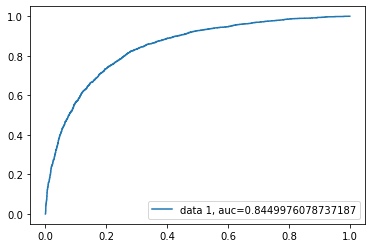

In [183]:
y_pred_proba = logreg2.predict_proba(test_x)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# XG BOOST CLASSIFIER

In [184]:
import xgboost
from xgboost import XGBClassifier
XGmodel =XGBClassifier(gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=11, seed=0, silent=True, subsample=1).fit(x_train,y_train)

[18:37:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Training_accuracy -  0.5790813779331003
Test_accuracy -  0.5730118316609256
F1_score_train -  0.5114972338190327
F1_score_test -  0.5047555477429541
Recall_train -  0.5790813779331003
Recall_test -  0.5730118316609256
Precision_train -  0.7607230251068186
Precision_test -  0.7422078665976822
Training_Confusion_Matrix -  [[2361 8347]
 [  84 9238]]


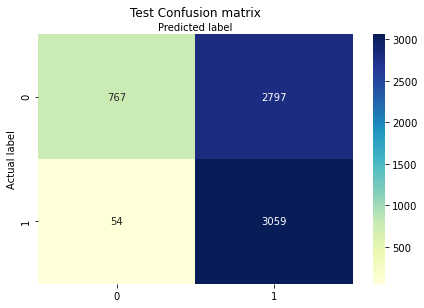

In [186]:
XG_training_labels, XG_test_labels = model_performance(XGmodel)

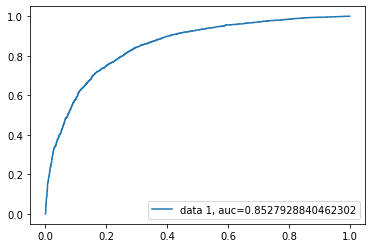

In [187]:
y_pred_proba = XGmodel.predict_proba(test_x)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# RANDOM FOREST CLASSIFIER

In [188]:
# ----------------- MODEL TRAINING USING RANDOM FOREST -------------------
RF_model2 = RandomForestClassifier(max_depth=6, random_state=0).fit(x_train,y_train)

Training_accuracy -  0.772890664003994
Test_accuracy -  0.7666616744046728
F1_score_train -  0.7720373133328379
F1_score_test -  0.7656830435820972
Recall_train -  0.772890664003994
Recall_test -  0.7666616744046728
Precision_train -  0.7731555905832702
Precision_test -  0.7670600020074259
Training_Confusion_Matrix -  [[8789 1919]
 [2630 6692]]


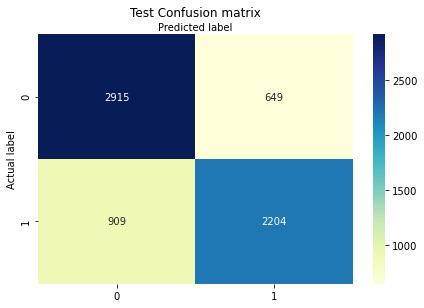

In [189]:
# -------------------- RANDOM FOREST RESULTS ------------------- 
RF_training_labels, RF_test_labels = model_performance(RF_model2)

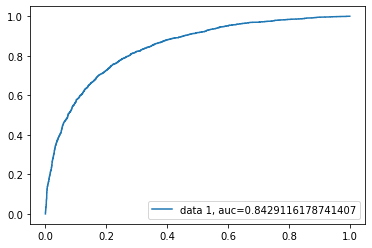

In [190]:
y_pred_proba = RF_model2.predict_proba(test_x)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# LGBM Classifier

In [191]:
# ------------------- MODEL TRAINING USING LightGBM ---------------------
LGBMClassifier2 = lgb.LGBMClassifier().fit(x_train,y_train)

Training_accuracy -  0.8099350973539691
Test_accuracy -  0.7807398532274974
F1_score_train -  0.8097744413369923
F1_score_test -  0.7805356409454214
Recall_train -  0.8099350973539691
Recall_test -  0.7807398532274974
Precision_train -  0.8097944377586174
Precision_test -  0.780545475764624
Training_Confusion_Matrix -  [[8910 1798]
 [2009 7313]]


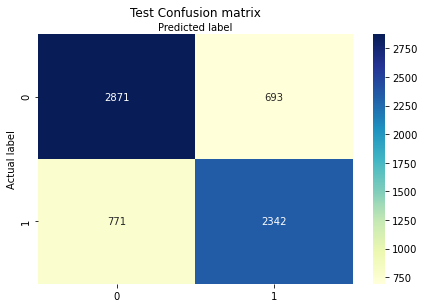

In [192]:
# -------------------- LIGHT GBM RESULTS ------------------- 
LGBM_training_labels, LGBM_test_labels = model_performance(LGBMClassifier2)

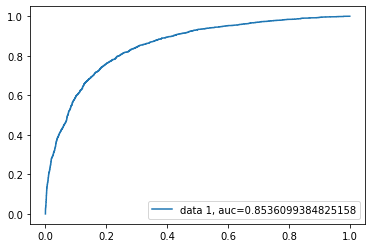

In [193]:
y_pred_proba = LGBMClassifier2.predict_proba(test_x)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()